 ## Step 1: Load & Clean Data

In [1]:
# ================================
# 📦 Imports
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values
df['TotalCharges'] = df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'])

# Drop ID column
df.drop('customerID', axis=1, inplace=True)

# Encode target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


## Step 2: EDA

Dataset Shape: (7043, 20)

Missing values:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


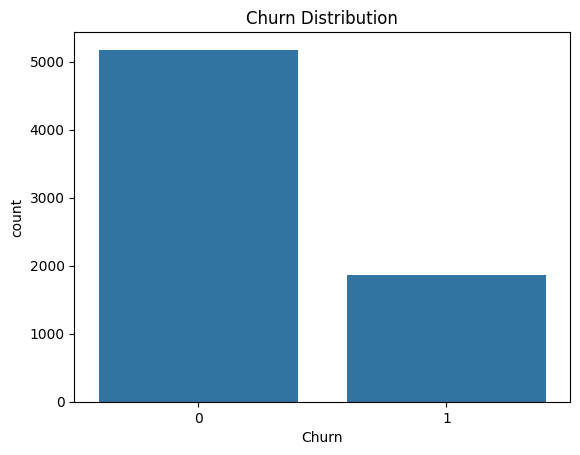

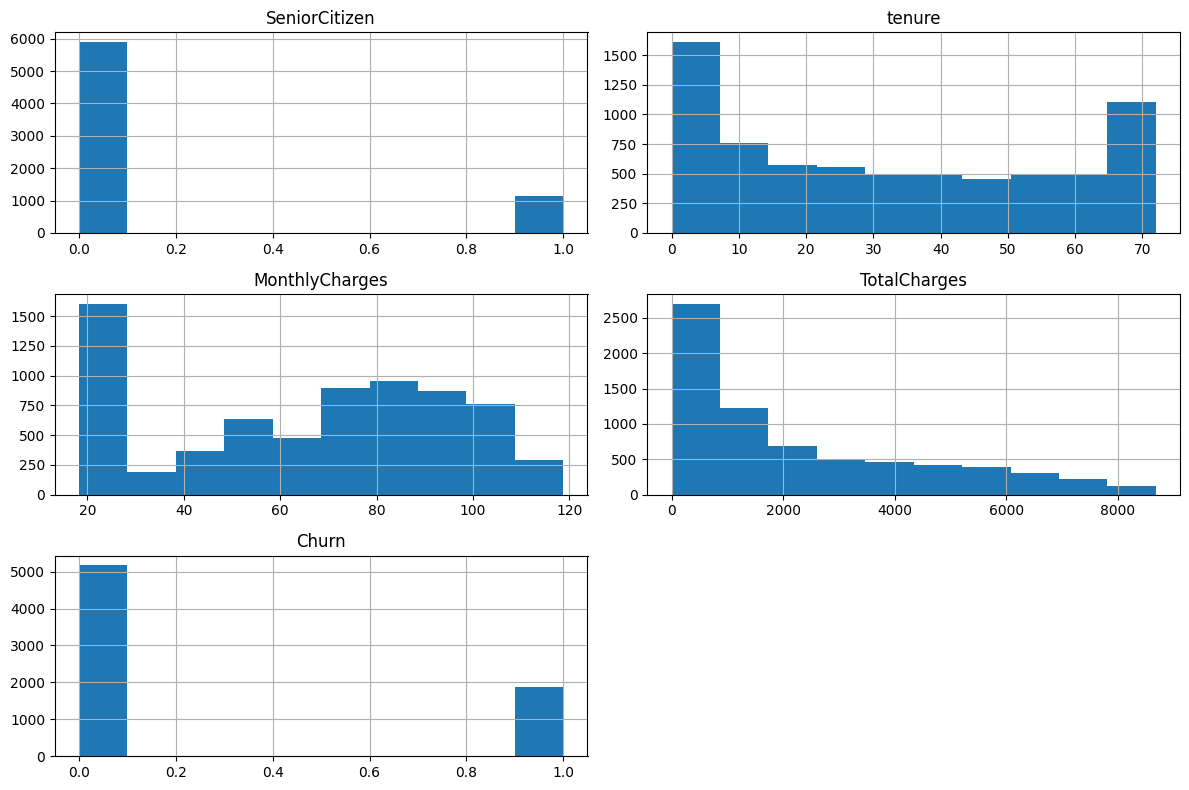

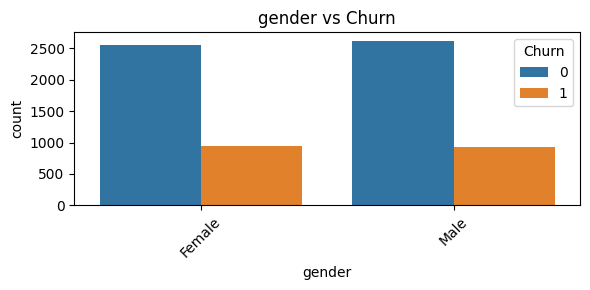

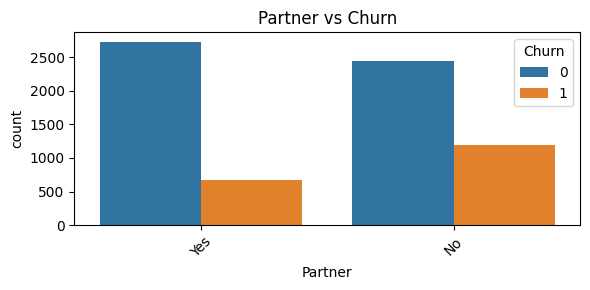

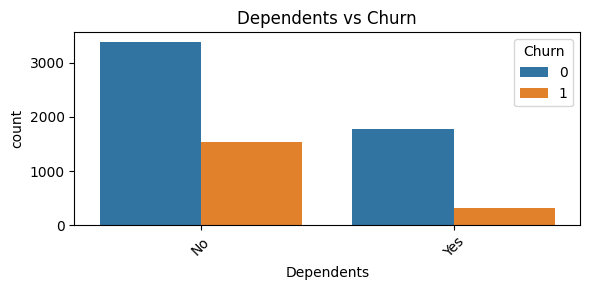

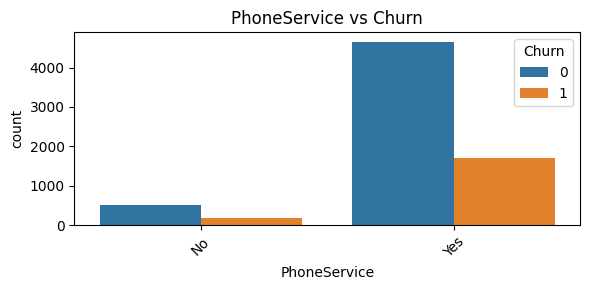

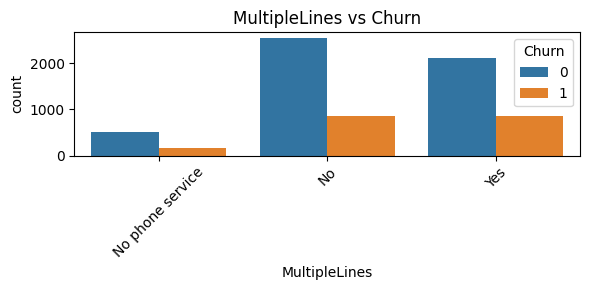

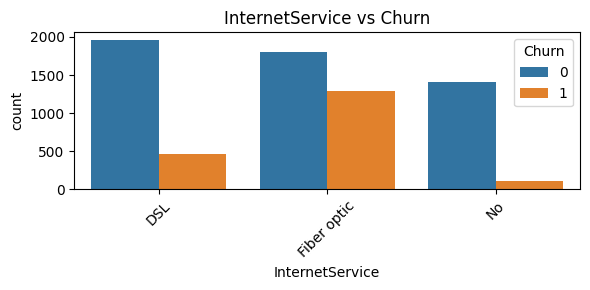

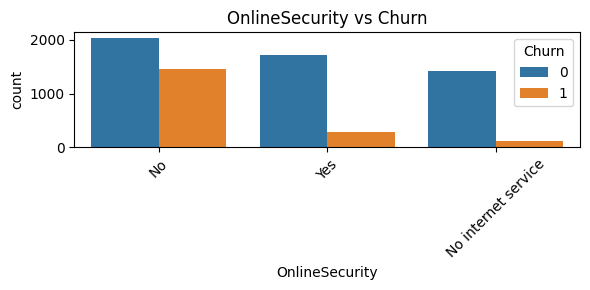

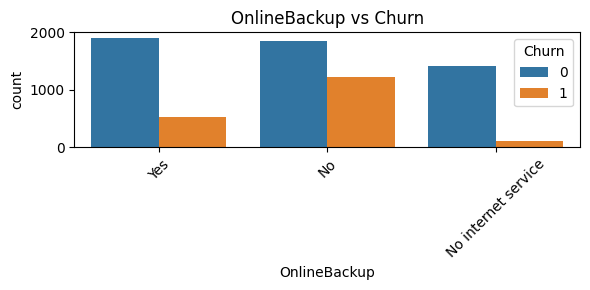

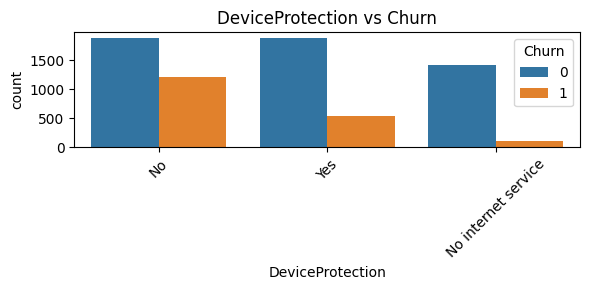

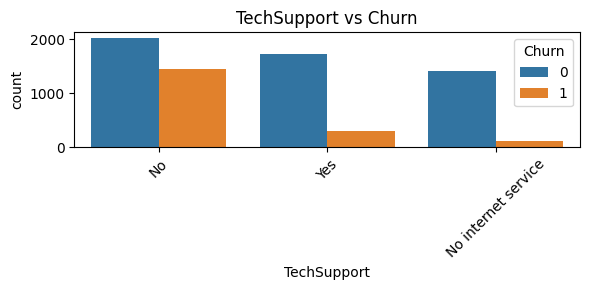

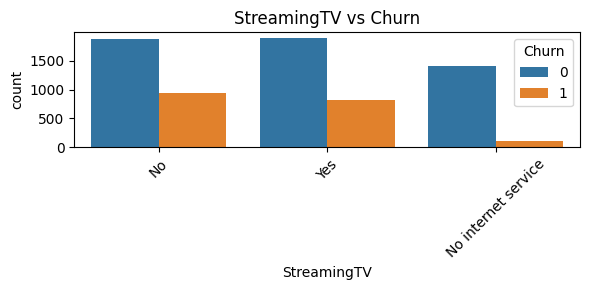

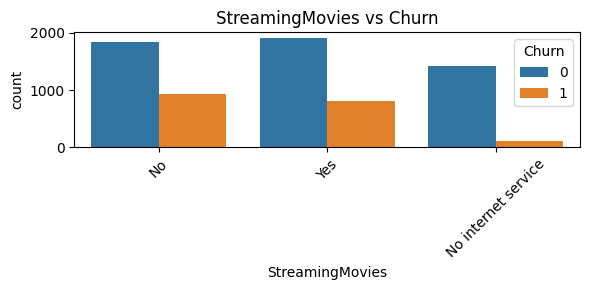

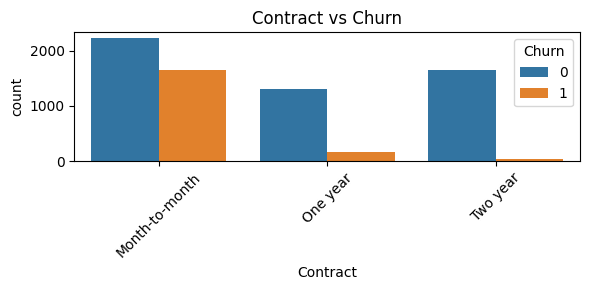

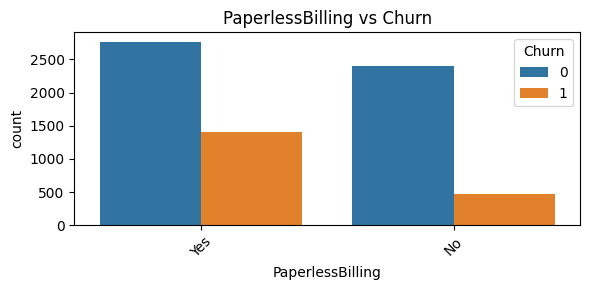

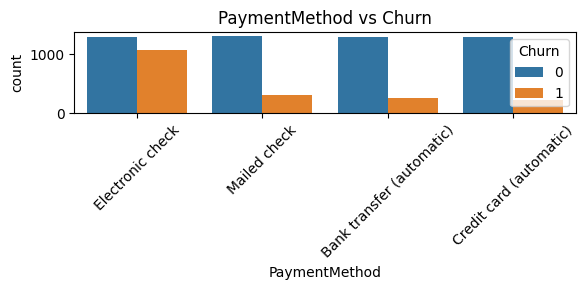

In [3]:
print("Dataset Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

# Churn distribution
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.show()

# Histograms for numeric features
df.select_dtypes(include=np.number).hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Categorical feature counts
categorical_features = df.select_dtypes(include='object').columns
for col in categorical_features:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Step 3: Encoding + Scaling

In [4]:
X = df.drop('Churn', axis=1)
y = df['Churn']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

## Step 4: Model Pipelines

In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

## Step 5: Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Step 6: Train & Evaluate


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC Score: 0.8421349040274871


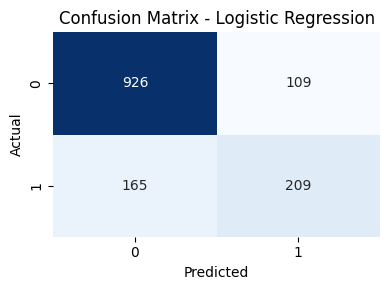


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409

ROC AUC Score: 0.8185099072567104


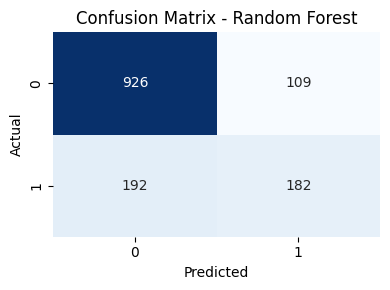


===== XGBoost =====
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409

ROC AUC Score: 0.8151941408974658


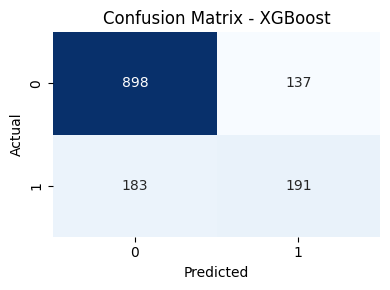


===== CatBoost =====
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC Score: 0.8430687953705857


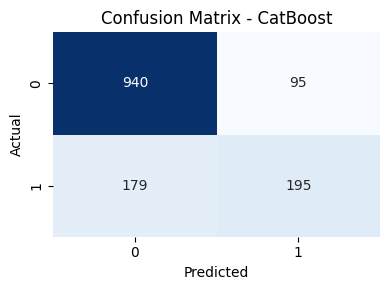

In [14]:

# To store results
results = []
trained_catboost_model = None

for name, model in models.items():
    print(f"\n===== {name} =====")
    
    if name == "CatBoost":
        # Separate out CatBoost training since it handles categorical features natively
        catboost_model = CatBoostClassifier(verbose=0, random_state=42)

        # Get categorical column indices for CatBoost
        cat_features_indices = [X.columns.get_loc(col) for col in categorical_cols]

        # Fit model
        catboost_model.fit(X_train, y_train, cat_features=cat_features_indices)
        trained_catboost_model = catboost_model  # ✅ Save for later

        # Predict
        y_pred = catboost_model.predict(X_test)
        y_proba = catboost_model.predict_proba(X_test)[:, 1]
    else:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    # 📊 Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Store metrics
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })


## Step 7: Display Comparison

In [15]:
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("\n🔍 Model Performance Comparison:\n")
print(results_df)


🔍 Model Performance Comparison:

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
3             CatBoost  0.805536   0.672414  0.521390  0.587349  0.843069
0  Logistic Regression  0.805536   0.657233  0.558824  0.604046  0.842135
1        Random Forest  0.786373   0.625430  0.486631  0.547368  0.818510
2              XGBoost  0.772889   0.582317  0.510695  0.544160  0.815194


## SHAP and Feature Importance

### 🔍 Why SHAP and Feature Importance Matter

Understanding why a machine learning model makes certain predictions is crucial for gaining trust and making actionable decisions—especially in business problems like customer churn.

- **Feature Importance** gives a global view of which variables most influence the model's predictions.
- **SHAP (SHapley Additive exPlanations)** goes deeper by explaining individual predictions, showing how each feature contributes to a specific output (e.g., why a customer was predicted to churn).

This is particularly useful for:
- Identifying controllable business factors (e.g., contract length, payment method)
- Justifying model decisions to stakeholders
- Tailoring retention strategies for individual customers


In [16]:
# Feature Importance (global)
from catboost import Pool

feature_importance = trained_catboost_model.get_feature_importance(
    Pool(X_train, label=y_train, cat_features=cat_features_indices),
    prettified=True
)
feature_importance.head(10)


,Feature Id,Importances
0,tenure,14.251352
1,TotalCharges,13.862355
2,Contract,12.434406
3,MonthlyCharges,11.747791
4,InternetService,8.132057
5,PaymentMethod,5.525239
6,OnlineSecurity,5.458626
7,OnlineBackup,4.929323
8,MultipleLines,4.056386
9,PaperlessBilling,3.530562


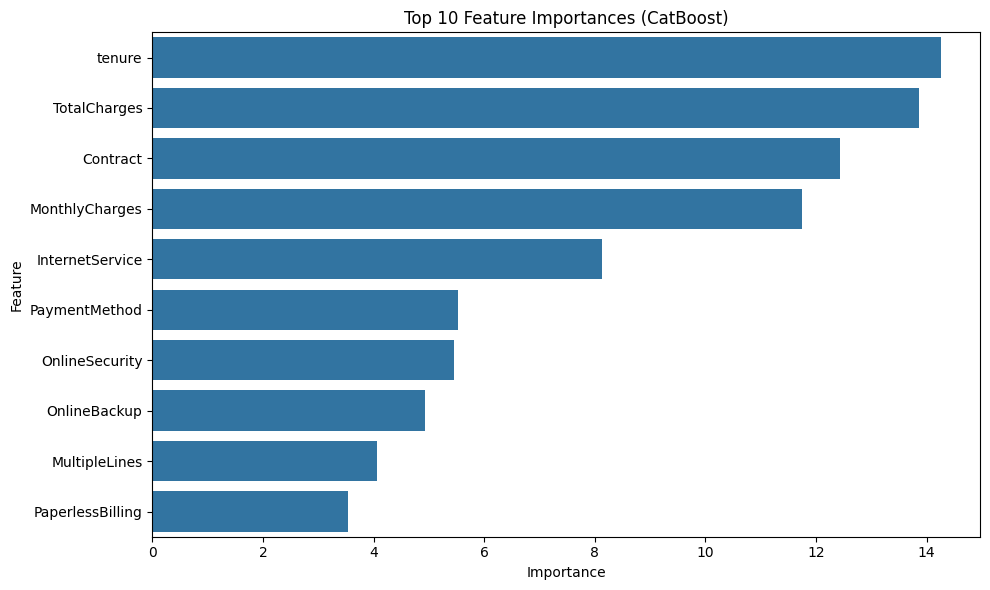

In [17]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importances', y='Feature Id')
plt.title("Top 10 Feature Importances (CatBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## SHAP Explanation for CatBoost

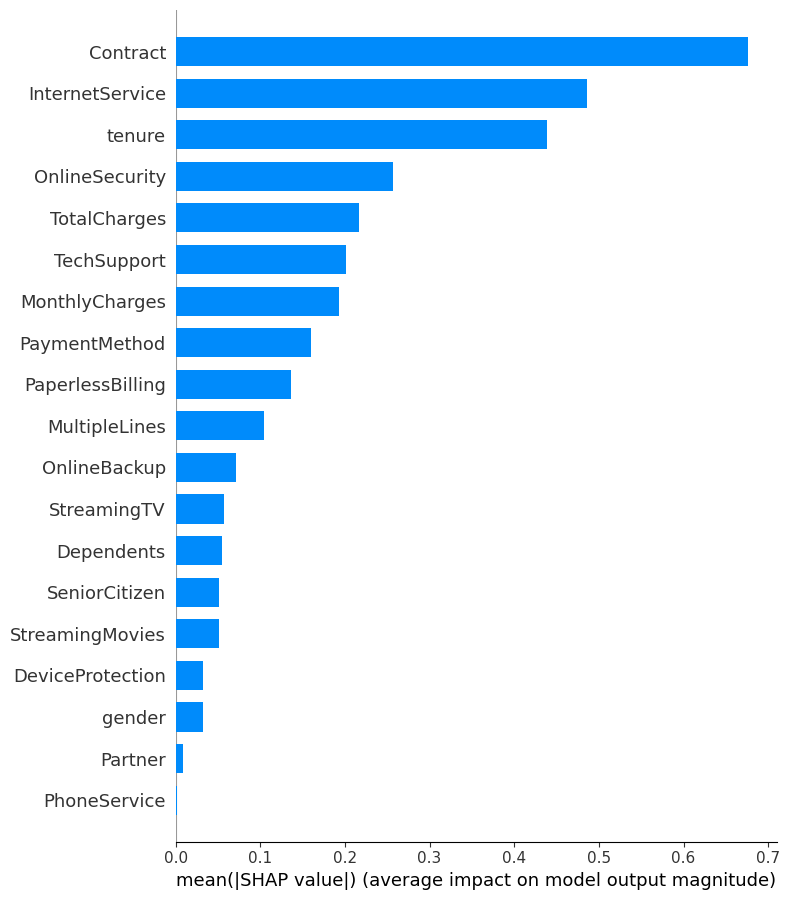

In [18]:
import shap

# Initialize SHAP
explainer = shap.TreeExplainer(trained_catboost_model)
shap_values = explainer.shap_values(X_test)

# Summary plot (top features)
shap.summary_plot(shap_values, X_test, plot_type="bar")


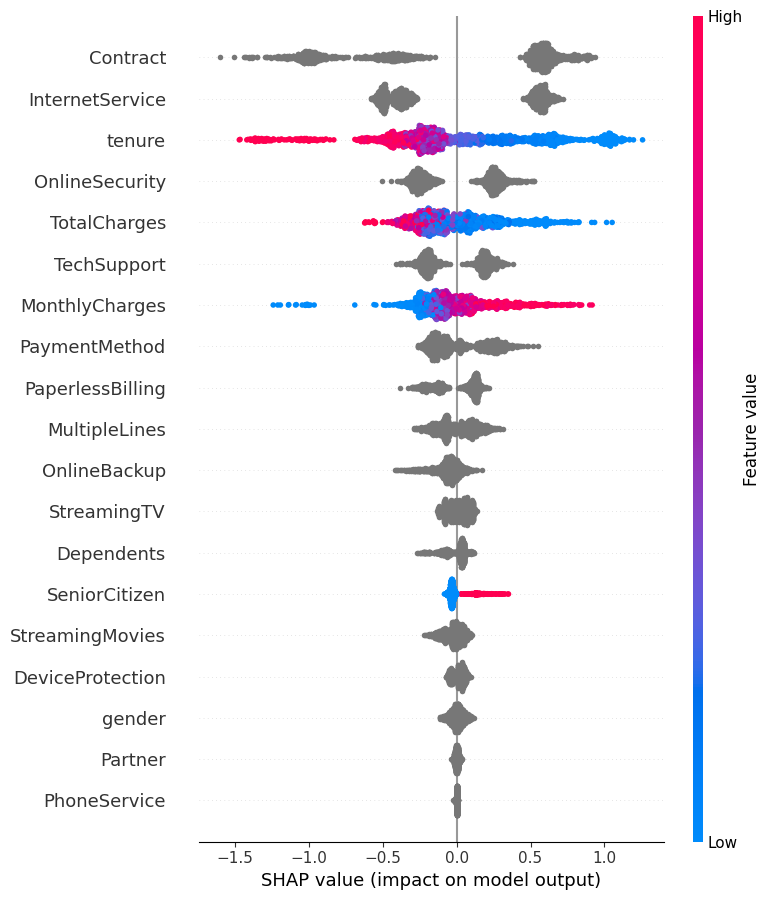

In [19]:
# Detailed SHAP summary (beeswarm)
shap.summary_plot(shap_values, X_test)


In [20]:
# Individual customer prediction explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


## Save Model and SHAP Explainer

In [24]:
# Save CatBoost model
trained_catboost_model.save_model("../model/catboost_model.cbm")

# Save SHAP explainer
import joblib
joblib.dump(explainer, "../utils/shap_explainer.pkl")

['../utils/shap_explainer.pkl']